In [45]:
import pickle
import warnings
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import vggish.vggish as vggish
import matplotlib.pyplot as plt
from sklearn import tree, neighbors
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import IPython.display as ipd

%matplotlib inline  

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df_openmic = pd.read_csv('openmic/openmic-2018-aggregated-labels.csv')
df_openmic.head()

,sample_key,instrument,relevance,num_responses
0,000046_3840,clarinet,0.17105,3
1,000046_3840,flute,0.00000,3
2,000046_3840,trumpet,0.00000,3
3,000135_483840,saxophone,0.14705,3
4,000135_483840,voice,1.00000,3


In [4]:
instruments = np.unique(df_openmic['instrument'])
instruments

array(['accordion', 'banjo', 'bass', 'cello', 'clarinet', 'cymbals',
       'drums', 'flute', 'guitar', 'mallet_percussion', 'mandolin',
       'organ', 'piano', 'saxophone', 'synthesizer', 'trombone',
       'trumpet', 'ukulele', 'violin', 'voice'], dtype=object)

In [5]:
class_map = {inst: i for i, inst in enumerate(instruments)}

In [6]:
OPENMIC = np.load('openmic/openmic.npz', allow_pickle=True)

In [7]:
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

In [8]:
split_train = pd.read_csv('openmic/partitions/split01_train.csv', header=None).squeeze()
split_test = pd.read_csv('openmic/partitions/split01_test.csv', header=None).squeeze()

In [9]:
print(f'Train: {len(split_train)}\nTest: {len(split_test)}')

Train: 14915
Test: 5085


In [10]:
train_set = set(split_train)
test_set = set(split_test)

In [11]:
idx_train, idx_test = [], []

for idx, sk in enumerate(sample_key):
    if sk in train_set:
        idx_train.append(idx)
    elif sk in test_set:
        idx_test.append(idx)
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [12]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [37]:
for instrument in class_map:
    inst_num = class_map[instrument]

    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    X_train_inst = X_train[train_inst]
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.8
    
    X_test_inst = X_test[test_inst]
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.8

    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    clf.fit(X_train_inst_sklearn, Y_true_train_inst)

    Y_pred_train = clf.predict(X_train_inst_sklearn)
    Y_pred_test = clf.predict(X_test_inst_sklearn)
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    accuracy_scores.append(accuracy_score(Y_true_test_inst, Y_pred_test))
    f1_scores.append(f1_score(Y_true_test_inst, Y_pred_test))
        
    # with open(f'openmic/models/{instrument}.pkl', 'wb') as file:
    #     pickle.dump(clf, file)

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1161
        True       0.99      0.88      0.93       372

    accuracy                           0.97      1533
   macro avg       0.98      0.94      0.96      1533
weighted avg       0.97      0.97      0.97      1533

	TEST
              precision    recall  f1-score   support

       False       0.84      0.96      0.90       423
        True       0.71      0.32      0.44       115

    accuracy                           0.83       538
   macro avg       0.78      0.64      0.67       538
weighted avg       0.81      0.83      0.80       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1149
        True       0.97      0.96      0.97       591

    accuracy                           0

In [42]:
accuracy_scores = []
f1_scores = []

In [43]:
test_cm = {'bass':  0, 'drums': 1, 'guitar': 2, 'piano': 3, 'synthesizer': 4, 'voice': 5}

for instrument in test_cm:
    inst_num = test_cm[instrument]

    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    X_train_inst = X_train[train_inst]
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.8
    
    X_test_inst = X_test[test_inst]
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.8

    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    clf.fit(X_train_inst_sklearn, Y_true_train_inst)

    Y_pred_train = clf.predict(X_train_inst_sklearn)
    Y_pred_test = clf.predict(X_test_inst_sklearn)
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    accuracy_scores.append(accuracy_score(Y_true_test_inst, Y_pred_test))
    f1_scores.append(f1_score(Y_true_test_inst, Y_pred_test))
        
    # with open(f'openmic/models/{instrument}.pkl', 'wb') as file:
    #     pickle.dump(clf, file)

----------------------------------------------------
bass
	TRAIN
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1161
        True       0.99      0.88      0.93       372

    accuracy                           0.97      1533
   macro avg       0.98      0.94      0.96      1533
weighted avg       0.97      0.97      0.97      1533

	TEST
              precision    recall  f1-score   support

       False       0.84      0.96      0.90       423
        True       0.71      0.32      0.44       115

    accuracy                           0.83       538
   macro avg       0.78      0.64      0.67       538
weighted avg       0.81      0.83      0.80       538

----------------------------------------------------
drums
	TRAIN
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1149
        True       0.97      0.96      0.97       591

    accuracy                           0.98  

In [59]:
all_predictions = []
all_labels = []
test_cm = {'bass':  0, 'drums': 1, 'guitar': 2, 'piano': 3, 'synthesizer': 4, 'voice': 5}

for instrument in test_cm:
    inst_num = test_cm[instrument]

    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    X_train_inst = X_train[train_inst]
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.8
    
    X_test_inst = X_test[test_inst]
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.8

    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
    
    clf.fit(X_train_inst_sklearn, Y_true_train_inst)

    Y_pred_train = clf.predict(X_train_inst_sklearn)
    Y_pred_test = clf.predict(X_test_inst_sklearn)
    
    all_predictions.extend(Y_pred_test)
    all_labels.extend(Y_true_test_inst)

In [64]:
report

{'False': {'precision': 0.8237905015534842,
  'recall': 0.9317269076305221,
  'f1-score': 0.8744405182567726,
  'support': 1992},
 'True': {'precision': 0.8271918678526048,
  'recall': 0.6211832061068703,
  'f1-score': 0.7095367847411446,
  'support': 1048},
 'accuracy': 0.8246710526315789,
 'macro avg': {'precision': 0.8254911847030445,
  'recall': 0.7764550568686962,
  'f1-score': 0.7919886514989586,
  'support': 3040},
 'weighted avg': {'precision': 0.8249630778302863,
  'recall': 0.8246710526315789,
  'f1-score': 0.8175921259132272,
  'support': 3040}}

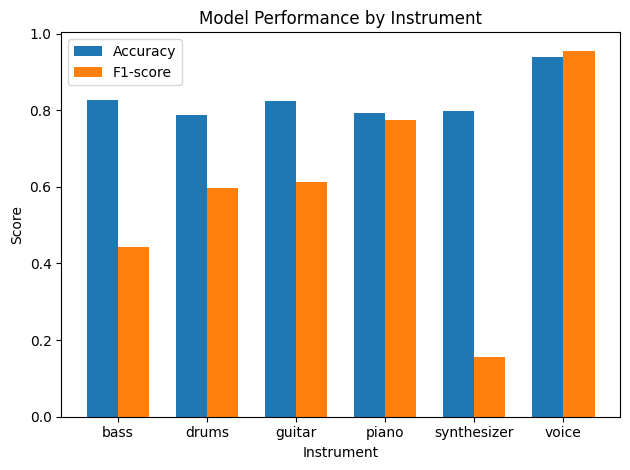

In [45]:
instruments = list(test_cm.keys())
x = np.arange(len(instruments))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-score')

ax.set_xticks(x)
ax.set_xticklabels(instruments)
ax.legend()

ax.set_xlabel('Instrument')
ax.set_ylabel('Score')
ax.set_title('Model Performance by Instrument')

plt.tight_layout()
plt.show()

In [51]:
list(test_cm.keys())

['bass', 'drums', 'guitar', 'piano', 'synthesizer', 'voice']

In [13]:
knb = neighbors.KNeighborsClassifier()
gbc = GradientBoostingClassifier()
dt = tree.DecisionTreeClassifier()
rt = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
models = [knb, gbc, dt, rt]

In [ ]:
model_names = []
train_accuracies = []
test_accuracies = []

for model in models:
    total_train_accuracy = []
    total_test_accuracy = []
    
    for idx, instrument in enumerate(class_map):
        train_inst = Y_mask_train[:, idx]
        test_inst = Y_mask_test[:, idx]

        X_train_inst = X_train[train_inst]
        X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
        Y_true_train_inst = Y_true_train[train_inst, idx] >= 0.8

        X_test_inst = X_test[test_inst]
        X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
        Y_true_test_inst = Y_true_test[test_inst, idx] >= 0.8
        
        model.fit(X_train_inst_sklearn, Y_true_train_inst)

        Y_pred_train = model.predict(X_train_inst_sklearn)
        Y_pred_test = model.predict(X_test_inst_sklearn)

        instrument_train_accuracy = accuracy_score(Y_true_train_inst, Y_pred_train)
        instrument_test_accuracy = accuracy_score(Y_true_test_inst, Y_pred_test)

        total_train_accuracy.append(instrument_train_accuracy)
        total_test_accuracy.append(instrument_test_accuracy)
    
    avg_train_accuracy = np.mean(total_train_accuracy)
    avg_test_accuracy = np.mean(total_test_accuracy)

    model_names.append(model.__class__.__name__)
    train_accuracies.append(avg_train_accuracy)
    test_accuracies.append(avg_test_accuracy)

In [ ]:
overall_acc = []

for i in range(len(train_accuracies)):
    overall_acc.append((train_accuracies[i] + test_accuracies[i])/2)

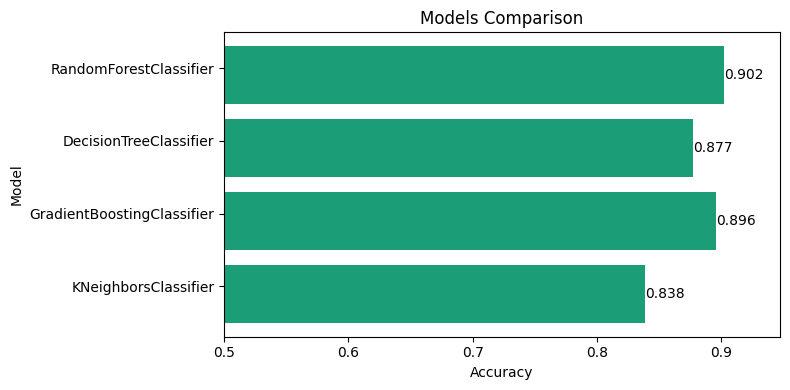

In [31]:
# plt.switch_backend('Agg')

fig, ax = plt.subplots(figsize=(8,4))
opacity = 0.8
index = np.arange(len(models))
bar_width = 0.2

ax.barh(model_names, overall_acc, color='#1b9e77')

ax.set_ylabel('Model')
ax.set_xlabel('Accuracy')
ax.set_title('Models Comparison')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(model_names)

ax.set_xlim(0.5)  # Set the y-axis limits to start from 0.5
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

for i, v in enumerate(overall_acc):
    ax.text(v, i, str(round(v, 3)), color='black', ha='left', va='center')

plt.tight_layout()
# plt.savefig('images/models-comparison.png')
plt.show()

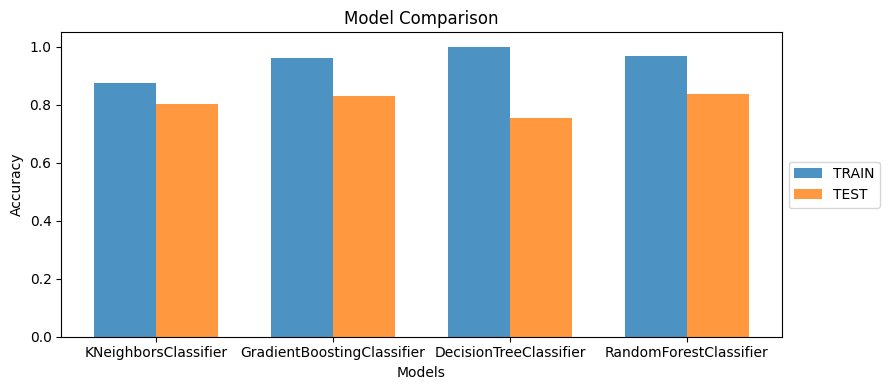

In [71]:
fig, ax = plt.subplots(figsize=(9,4))
bar_width = 0.35
opacity = 0.8
index = np.arange(len(models))

ax.bar(index, train_accuracies, bar_width, alpha=opacity, label='TRAIN')
ax.bar(index + bar_width, test_accuracies, bar_width, alpha=opacity, label='TEST')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## Curva Roc

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=.25, random_state=42)

fig = plt.figure(figsize=(16,12))

for model in models:
    model = model.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, yproba) #TODO!!
    auc = roc_auc_score(y_test, yproba) #TODO!!
    
    plt.plot(fpr, tpr, label="{}, AUC={}".format(model.__class__.__name__, auc))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("FPR", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("TPR", fontsize=15)

plt.title('Comparativo dos Modelos (usando ROC Curve)', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [4]:
def remove_silence(y):
    db = librosa.core.amplitude_to_db(y)
    mean_db = np.abs(db).mean()
    splitted_audio = librosa.effects.split(y=y, top_db=mean_db)

    silence_removed = []

    for inter in splitted_audio:
        silence_removed.extend(y[inter[0]:inter[1]])

    return np.array(silence_removed)

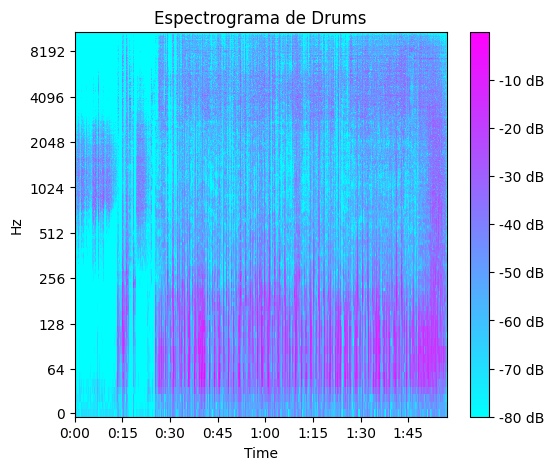

In [12]:
audio1, sr1 = librosa.load('separated/htdemucs_6s/bohemian_rhapsody/drums.wav')
audio_splitted1 = remove_silence(audio1)

D1 = np.abs(librosa.stft(audio_splitted1, n_fft=n_fft, hop_length=hop_length))
db1 = librosa.amplitude_to_db(D1, ref=np.max)

plt.figure(figsize=(6, 5))
librosa.display.specshow(db1, sr=sr1, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Drums')
plt.show()

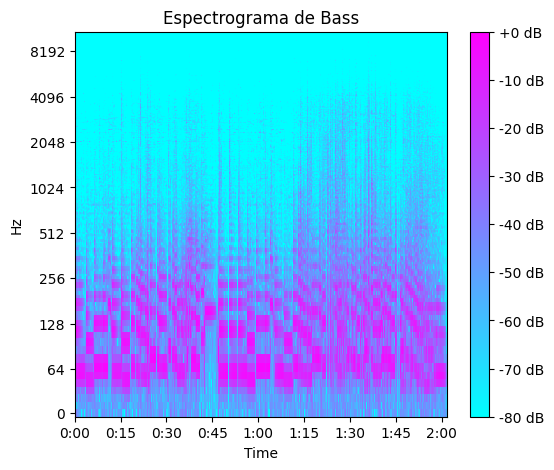

In [13]:
audio2, sr2 = librosa.load('separated/htdemucs_6s/bohemian_rhapsody/bass.wav')
audio_splitted2 = remove_silence(audio2)

D2 = np.abs(librosa.stft(audio_splitted2, n_fft=n_fft, hop_length=hop_length))
db2 = librosa.amplitude_to_db(D2, ref=np.max)

plt.figure(figsize=(6, 5))
librosa.display.specshow(db2, sr=sr2, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Bass')
plt.show()

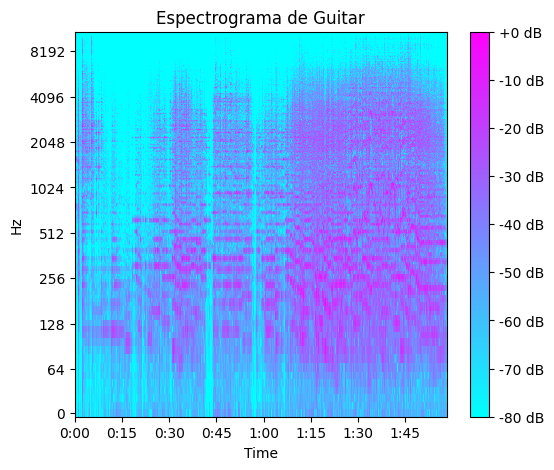

In [14]:
audio3, sr3 = librosa.load('separated/htdemucs_6s/bohemian_rhapsody/guitar.wav')
audio_splitted3 = remove_silence(audio3)

D3 = np.abs(librosa.stft(audio_splitted3, n_fft=n_fft, hop_length=hop_length))
db3 = librosa.amplitude_to_db(D3, ref=np.max)

plt.figure(figsize=(6, 5))
librosa.display.specshow(db3, sr=sr3, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Guitar')
plt.show()

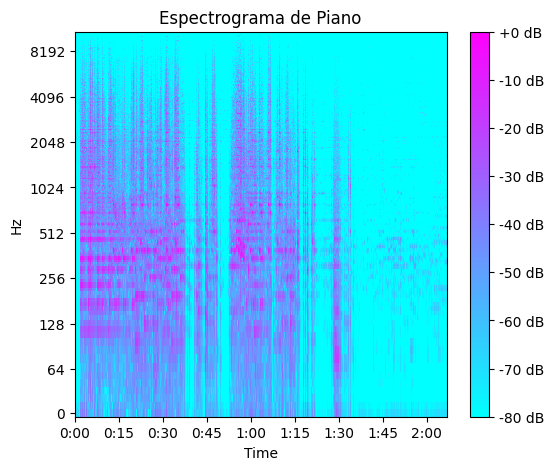

In [15]:
audio4, sr4 = librosa.load('separated/htdemucs_6s/bohemian_rhapsody/piano.wav')
audio_splitted4 = remove_silence(audio4)

D4 = np.abs(librosa.stft(audio_splitted4, n_fft=n_fft, hop_length=hop_length))
db4 = librosa.amplitude_to_db(D4, ref=np.max)

plt.figure(figsize=(6, 5))
librosa.display.specshow(db4, sr=sr4, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Piano')
plt.show()

In [2]:
hop_length = 512
n_fft = 2048

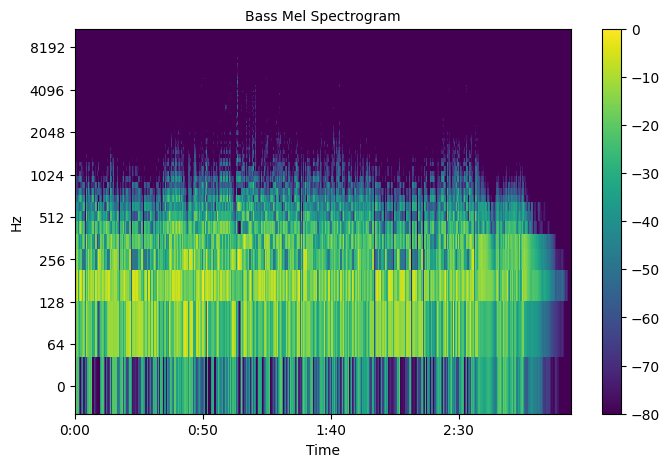

In [32]:
y, sr = librosa.load('separated/htdemucs_6s/nothing_else_matters/bass.wav')
y_splitted = remove_silence(y)

s = librosa.feature.melspectrogram(y=y_splitted, sr=sr)
s_db = librosa.amplitude_to_db(s, ref=np.max)
plt.figure(figsize=(8, 5))
librosa.display.specshow(s_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title("Bass Mel Spectrogram", fontsize=10);
plt.show()

In [34]:
y_bass, sr_bass = librosa.load('separated/htdemucs_6s/nothing_else_matters/bass.wav')
y_drums, sr_drums = librosa.load('separated/htdemucs_6s/nothing_else_matters/drums.wav')
y_guitar, sr_guitar = librosa.load('separated/htdemucs_6s/nothing_else_matters/guitar.wav')
y_vocals, sr_vocals = librosa.load('separated/htdemucs_6s/nothing_else_matters/vocals.wav')

In [35]:
y_bass_splitted = remove_silence(y_bass)
y_drums_splitted = remove_silence(y_drums)
y_guitar_splitted = remove_silence(y_guitar)
y_vocals_splitted = remove_silence(y_vocals)

In [42]:
s_bass = librosa.feature.melspectrogram(y=y_bass_splitted, sr=sr_bass)
s_drums = librosa.feature.melspectrogram(y=y_drums_splitted, sr=sr_drums)
s_guitar = librosa.feature.melspectrogram(y=y_guitar_splitted, sr=sr_guitar)
s_vocals = librosa.feature.melspectrogram(y=y_vocals_splitted, sr=sr_vocals)

In [43]:
s_db_bass = librosa.amplitude_to_db(s_bass, ref=np.max)
s_db_drums = librosa.amplitude_to_db(s_drums, ref=np.max)
s_db_guitar = librosa.amplitude_to_db(s_guitar, ref=np.max)
s_db_vocals = librosa.amplitude_to_db(s_vocals, ref=np.max)

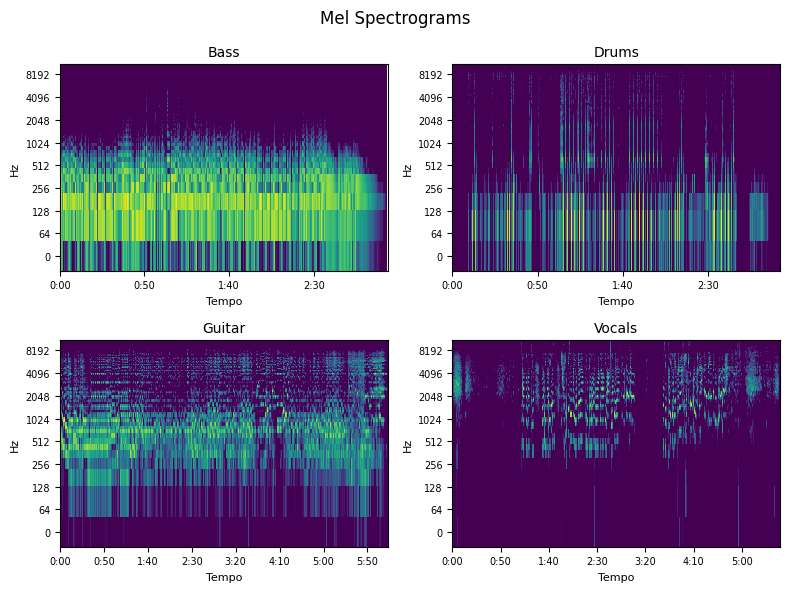

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

librosa.display.specshow(s_db_bass, sr=sr_bass, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis', ax=axs[0, 0])
axs[0, 0].set_title('Bass', fontsize=10)
axs[0, 0].set_xlabel('Tempo', fontsize=8)
axs[0, 0].set_ylabel('Hz', fontsize=8)

librosa.display.specshow(s_db_drums, sr=sr_drums, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis', ax=axs[0, 1])
axs[0, 1].set_title('Drums', fontsize=10)
axs[0, 1].set_xlabel('Tempo', fontsize=8)
axs[0, 1].set_ylabel('Hz', fontsize=8)

librosa.display.specshow(s_db_guitar, sr=sr_guitar, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis', ax=axs[1, 0])
axs[1, 0].set_title('Guitar', fontsize=10)
axs[1, 0].set_xlabel('Tempo', fontsize=8)
axs[1, 0].set_ylabel('Hz', fontsize=8)

librosa.display.specshow(s_db_vocals, sr=sr_vocals, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis', ax=axs[1, 1])
axs[1, 1].set_title('Vocals', fontsize=10)
axs[1, 1].set_xlabel('Tempo', fontsize=8)
axs[1, 1].set_ylabel('Hz', fontsize=8)

for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

plt.suptitle("Mel Spectrograms", fontsize=12);
plt.tight_layout()

plt.savefig('images/mel_spectrogram.png', dpi=300)

plt.show()

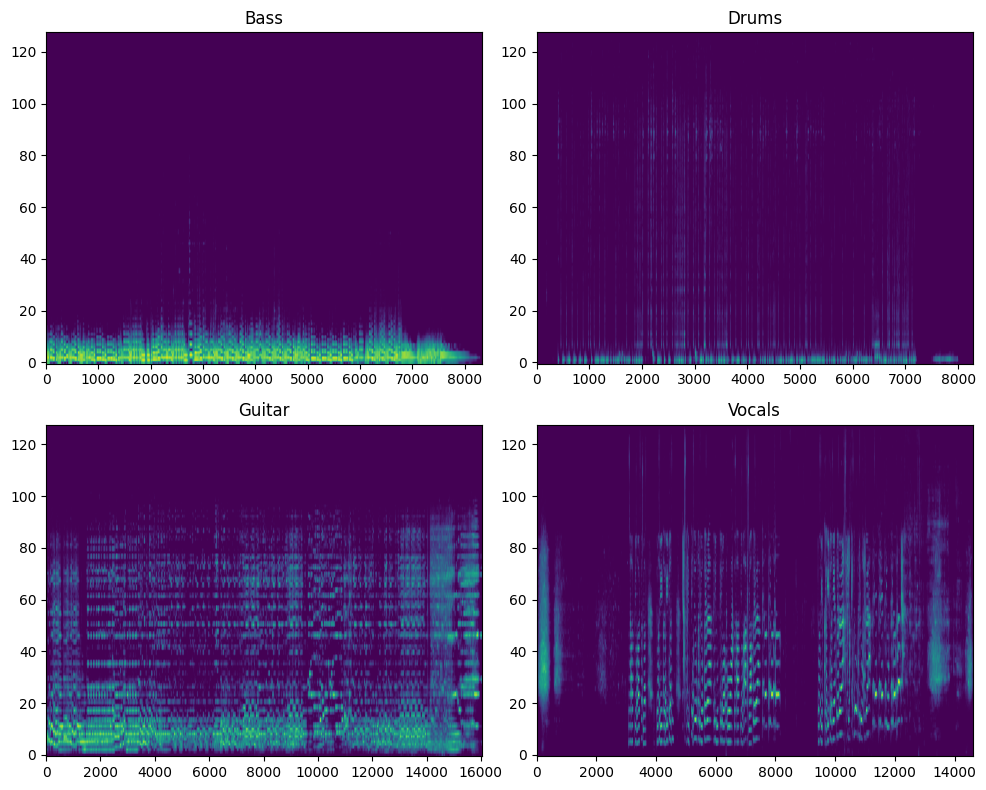

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].imshow(s_db_bass, origin='lower', aspect='auto', cmap='viridis')
axs[0, 0].set_title('Bass')

axs[0, 1].imshow(s_db_drums, origin='lower', aspect='auto', cmap='viridis')
axs[0, 1].set_title('Drums')

axs[1, 0].imshow(s_db_guitar, origin='lower', aspect='auto', cmap='viridis')
axs[1, 0].set_title('Guitar')

axs[1, 1].imshow(s_db_vocals, origin='lower', aspect='auto', cmap='viridis')
axs[1, 1].set_title('Vocals')

plt.tight_layout()

plt.show()

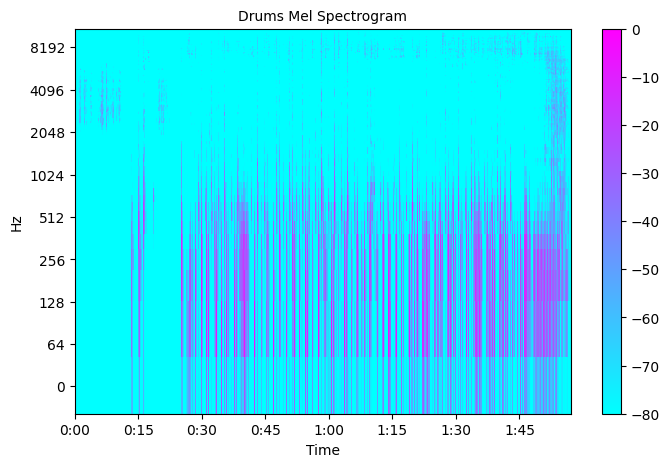

In [8]:
y, sr = librosa.load('separated/htdemucs_6s/nothing_else_matters/drums.wav')
y_splitted = remove_silence(y)

s = librosa.feature.melspectrogram(y=y_splitted, sr=sr)
s_db = librosa.amplitude_to_db(s, ref=np.max)
plt.figure(figsize=(8, 5))
librosa.display.specshow(s_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Drums Mel Spectrogram", fontsize=10);
plt.show()

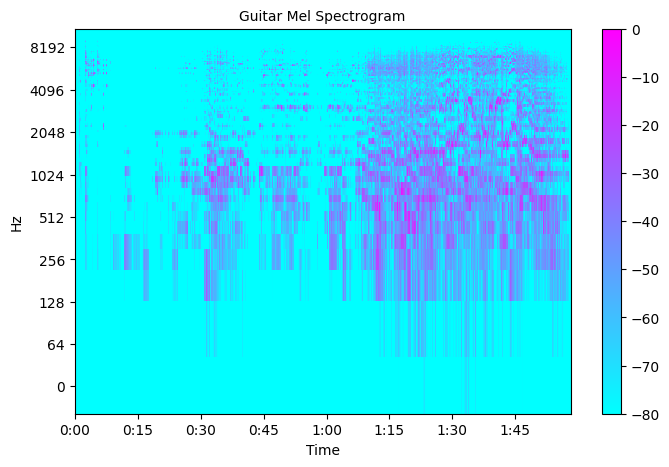

In [9]:
y, sr = librosa.load('separated/htdemucs_6s/nothing_else_matters/guitar.wav')
y_splitted = remove_silence(y)

s = librosa.feature.melspectrogram(y=y_splitted, sr=sr)
s_db = librosa.amplitude_to_db(s, ref=np.max)
plt.figure(figsize=(8, 5))
librosa.display.specshow(s_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Guitar Mel Spectrogram", fontsize=10);
plt.show()

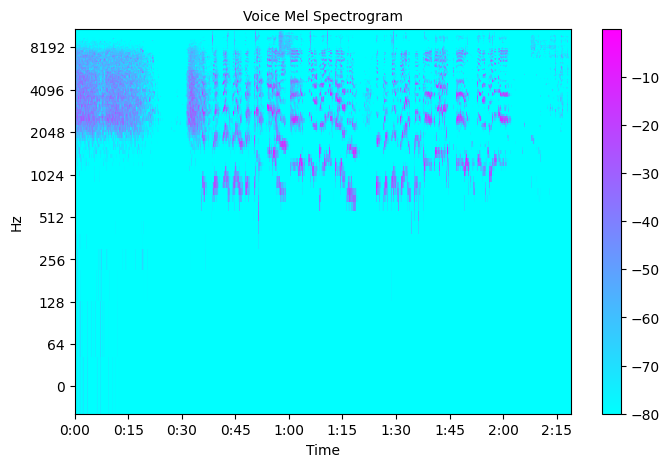

In [11]:
y, sr = librosa.load('separated/htdemucs_6s/nothing_else_matters/vocals.wav')
y_splitted = remove_silence(y)

s = librosa.feature.melspectrogram(y=y_splitted, sr=sr)
s_db = librosa.amplitude_to_db(s, ref=np.max)
plt.figure(figsize=(8, 5))
librosa.display.specshow(s_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Voice Mel Spectrogram", fontsize=10);
plt.show()